In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.dates as mdates
from scipy.signal import find_peaks
import openmeteo_requests
import requests_cache
from datetime import date, timedelta

#### Read in Data

Nur wenn "gebundelte_eco_counter_fahrradzaehler_bw.xlsx" noch nicht existiert, ansonsten skippen!

In [2]:
# Pfad zur Excel-Datei
excel_path = "../data/gebundelte_eco_counter_fahrradzaehler_bw.xlsx"

# Excel-Datei einlesen
df = pd.read_excel(excel_path)

# Zeilen filtern, deren 'data_description' "CSV" enthält
filtered_df = df[df['data_description'].str.contains("CSV", case=False, na=False)]

# URLs extrahieren
url_list = filtered_df['data_download_url'].dropna().tolist()

# Ausgabe (optional)
#for url in url_list:
#    print(url)

general_columns = pd.read_csv(url_list[1]).columns.tolist()

# Erstelle CSV-Datei, in der Daten aller URLs gespeichert werden
all_data = pd.DataFrame()
for url in url_list:
    csv_data = pd.read_csv(url)
    assert list(csv_data.columns) == general_columns, f"Spalten stimmen nicht überein in {url}"
    all_data = pd.concat([all_data, csv_data], ignore_index=True)

# Speichere all_data lokal als CSV-Datei
all_data.to_csv("alle_fahrradzaehler_daten.csv", index=False)   
all_data.head() 

C:\Users\grube\AppData\Local\Temp\ipykernel_18392\3562265386.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)
C:\Users\grube\AppData\Local\Temp\ipykernel_18392\3562265386.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)
C:\Users\grube\AppData\Local\Temp\ipykernel_18392\3562265386.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)
C:\Users\grube\AppData\Local\Temp\ipykernel_18392\3562265386.py:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv(url)


,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2013-01-01T01:00:00+0000,2013-01-01T01:00:00+0100,15,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
1,2013-01-01T02:00:00+0000,2013-01-01T02:00:00+0100,17,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
2,2013-01-01T03:00:00+0000,2013-01-01T03:00:00+0100,14,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
3,2013-01-01T04:00:00+0000,2013-01-01T04:00:00+0100,13,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
4,2013-01-01T05:00:00+0000,2013-01-01T05:00:00+0100,9,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301


In [4]:
# Einlesen von alle_fahrradzaehler_daten.csv
data = pd.read_csv("../data/alle_fahrradzaehler_daten.csv")
data['iso_timestamp'] = pd.to_datetime(data['iso_timestamp'], utc = True, errors='coerce') # Isotimestamp is lokale Zeit und berücksichtigt Sommerzeit
data.head()

,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2013-01-01T01:00:00+0000,2013-01-01 00:00:00+00:00,15,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
1,2013-01-01T02:00:00+0000,2013-01-01 01:00:00+00:00,17,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
2,2013-01-01T03:00:00+0000,2013-01-01 02:00:00+00:00,14,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
3,2013-01-01T04:00:00+0000,2013-01-01 03:00:00+00:00,13,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301
4,2013-01-01T05:00:00+0000,2013-01-01 04:00:00+00:00,9,0,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,Stadt Karlsruhe,752,8.402715,49.007286,(UTC+01:00) Europe/Paris;DST,15,Y2H16070301


#### Check Data Set

TODO: Keep relevant checks for submission and clean up

In [13]:
# Check data 
print(data.info())
#print(data.describe())
#print(data.isnull().sum())
#print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16827970 entries, 0 to 16827969
Data columns (total 16 columns):
 #   Column           Dtype              
---  ------           -----              
 0   timestamp        object             
 1   iso_timestamp    datetime64[ns, UTC]
 2   zählstand        int64              
 3   stand            int64              
 4   standort         object             
 5   channel_name     object             
 6   channel_id       int64              
 7   counter_site     object             
 8   counter_site_id  int64              
 9   domain_name      object             
 10  domain_id        int64              
 11  longitude        float64            
 12  latitude         float64            
 13  timezone         object             
 14  interval         int64              
 15  counter_serial   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(6), object(7)
memory usage: 2.0+ GB
None


In [14]:
# Check for duplicates
duplicates = data.duplicated()
print(f"Anzahl der Duplikate: {duplicates.sum()}")

Anzahl der Duplikate: 0


In [ ]:
# TODO: at the moment not working due to datetime format
# Number of years in the dataset
data['year'] = data['timestamp'].dt.year()
print(f"Jahre im Datensatz: {data['year'].nunique()} - {data['year'].unique()}")

In [18]:
# Locations in data set
locations = data['standort'].unique()
print(f"Anzahl der Standorte: {len(locations)}")
print(f"Standorte:")
for loc in locations:
    print(loc)

Anzahl der Standorte: 19
Standorte:
Stadt Karlsruhe
Stadt Freiburg
Landeshauptstadt Stuttgart
Stadt Tübingen
Stadt Lörrach
Stadt Heilbronn
Stadt Mannheim
Stadt Kirchheim unter Teck
Stadt Heidelberg
Stadt Offenburg
Stadt Ludwisburg
Stadt Konstanz
Landkreis Böblingen
Ravensburg TWS GmbH and Co KG
Stadt Ulm
Stadtverwaltung Aalen
Stadt Reutlingen
Landratsamt Rems-Murr-Kreis
Stadt Singen


Note: counter = Gerät, channel = Richtung/Messspur

In [ ]:
"""
 # Check the amount of counters per location
counters_per_location = data.groupby('standort').agg(
    anzahl_counter=('counter_serial', 'nunique'),
    counter_sites=('counter_site', lambda x: ', '.join(sorted(set(x))))
).reset_index()

print("Anzahl der Zähler pro Standort:") 
counters_per_location
"""

In [19]:
counters_per_location = data.groupby('standort')['counter_site_id'].nunique()
counters_per_location

standort
Landeshauptstadt Stuttgart       15
Landkreis Böblingen               2
Landratsamt Rems-Murr-Kreis       8
Ravensburg TWS GmbH and Co KG     7
Stadt Freiburg                    4
Stadt Heidelberg                 15
Stadt Heilbronn                   4
Stadt Karlsruhe                   1
Stadt Kirchheim unter Teck        1
Stadt Konstanz                    5
Stadt Ludwisburg                 15
Stadt Lörrach                     2
Stadt Mannheim                   14
Stadt Offenburg                   1
Stadt Reutlingen                  8
Stadt Singen                      1
Stadt Tübingen                    3
Stadt Ulm                         1
Stadtverwaltung Aalen             1
Name: counter_site_id, dtype: int64

In [20]:
# Check, at which location (standort) counter_serial is null
null_serial_locations = data[data['counter_serial'].isnull()]['standort'].unique()
print(f"Standorte mit null counter_serial: {null_serial_locations}")

Standorte mit null counter_serial: ['Stadt Freiburg' 'Stadt Mannheim' 'Stadt Heidelberg'
 'Landeshauptstadt Stuttgart' 'Stadt Offenburg' 'Stadt Ludwisburg']


Beschreibung der Anzahl Channels pro Counter-Side:
count    108.000000
mean       2.907407
std        1.562032
min        1.000000
25%        2.000000
50%        2.000000
75%        4.000000
max       10.000000
Name: num_channels, dtype: float64

Beispiele:
                     standort  counter_site_id  num_channels
0  Landeshauptstadt Stuttgart        100034882             4
1  Landeshauptstadt Stuttgart        100034894             2
2  Landeshauptstadt Stuttgart        100042486             2
3  Landeshauptstadt Stuttgart        100042487             2
4  Landeshauptstadt Stuttgart        100060100             2


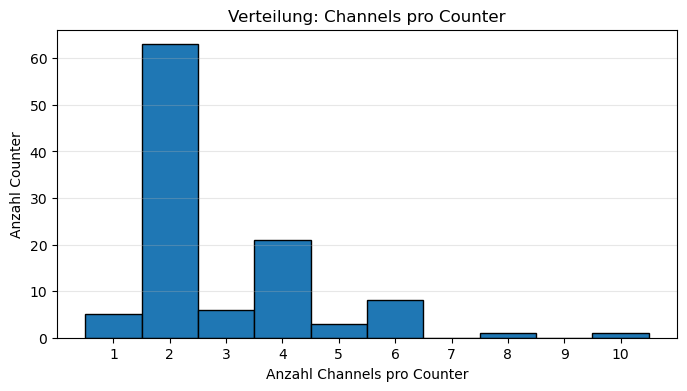

In [21]:
# Check how many channels there are for a counter site
channels_per_site = (
    data.groupby(['standort', 'counter_site_id'])['channel_name']
        .nunique()
        .reset_index(name='num_channels')
)

# Kurze Übersicht
print("Beschreibung der Anzahl Channels pro Counter-Side:")
print(channels_per_site['num_channels'].describe())
print("\nBeispiele:")
print(channels_per_site.head())

# Histogramm
plt.figure(figsize=(8,4))
max_bins = channels_per_site['num_channels'].max()
plt.hist(channels_per_site['num_channels'], bins=range(1, max_bins+2), align='left', edgecolor='black')
plt.xlabel('Anzahl Channels pro Counter')
plt.ylabel('Anzahl Counter')
plt.title('Verteilung: Channels pro Counter')
plt.xticks(range(1, max_bins+1))
plt.grid(axis='y', alpha=0.3)
plt.show()

##### Check Counter

In [22]:
# Check counter per city
city = "Stadt Heilbronn"
data_city = data[data['standort'] == city]
print(data_city["domain_id"].unique()[0])
counters = data_city[['counter_site', 'counter_site_id', 'counter_serial']].drop_duplicates().reset_index(drop=True)

channel_numbers = (
    data_city
    .groupby(['counter_site', 'counter_site_id', 'counter_serial'], dropna=False)['channel_id']
    .nunique()
    .reset_index()
    .rename(columns={'channel_id': 'channel_num'})
)
counters = counters.merge(channel_numbers, on=['counter_site', 'counter_site_id', 'counter_serial'], how='left')

tracking = data_city.groupby(['counter_site', 'counter_site_id', 'counter_serial'], dropna = False)['iso_timestamp'] \
    .agg(first_timestamp='min', last_timestamp='max') \
    .reset_index()
counters_with_tracking = counters.merge(tracking, on=['counter_site', 'counter_site_id', 'counter_serial'])

channel_lists = (
    data_city
    .groupby(['counter_site', 'counter_site_id', 'counter_serial'], dropna=False)['channel_name']
    .agg(lambda x: sorted(set(x)))   # sortiert + entfernt Duplikate
    .reset_index()
    .rename(columns={'channel_name': 'channel_names'})
)

counters_with_tracking = counters_with_tracking.merge(
    channel_lists,
    on=['counter_site', 'counter_site_id', 'counter_serial'],
    how='left'
)
counters_with_tracking

4100


,counter_site,counter_site_id,counter_serial,channel_num,first_timestamp,last_timestamp,channel_names
0,Neckarufer,100011532,YTG13104526,16,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00,"[15 < X <= 25 IN, 15 < X <= 25 OUT, 25 < X <= ..."
1,Route Nord,100027946,Y2H17052297,4,2016-03-10 23:00:00+00:00,2024-11-30 03:00:00+00:00,[Route Nord Fahrräder Fahrtrichtung Campuspark...
2,Route Süd,100027947,Y2H18024499,2,2016-03-10 23:00:00+00:00,2024-11-30 22:00:00+00:00,"[Route Süd Fahrräder Fahrtrichtung Flein, Rout..."
3,Neckarbogen,100064303,YTH20093883,6,2020-10-20 22:00:00+00:00,2024-12-01 00:00:00+00:00,"[Channel 1 IN, Channel 2 OUT, Channel 3 IN, Ch..."


In [23]:
# Ausgeben aller Channel-Namen für die gewählte Stadt:
for names in counters_with_tracking['channel_names'].tolist():
    print(names) 

['15 < X <= 25 IN', '15 < X <= 25 OUT', '25 < X <= 35 IN', '25 < X <= 35 OUT', '< 15 OUT', '<15 IN', '> 35 IN', '> 35 OUT', 'Neckarufer [Bike IN]', 'Neckarufer [Bike OUT]']
['Route Nord Fahrräder Fahrtrichtung Campuspark', 'Route Nord Fahrräder Fahrtrichtung Innenstadt']
['Route Süd Fahrräder Fahrtrichtung Flein', 'Route Süd Fahrräder Fahrtrichtung Innenstadt']
['Channel 1 IN', 'Channel 2 OUT', 'Channel 3 IN', 'Channel 4 OUT', 'Channel 5 IN', 'Channel 6 OUT']


In [24]:
# Überblick für einen bestimmten Counter (in der gewählten Stadt), 
# wie viele Channels es zu den Namen gibt und seit/ bis wann Daten vorliegen

counter_site = 'Neckarufer'

data_counter_site = data_city[data_city['counter_site'] == counter_site]
ids_names_map = data_counter_site.groupby('channel_name')['channel_id'].agg(lambda x: sorted(set(x))).reset_index().rename(columns={'channel_id': 'channel_ids'})
ids_names_map

ids_names = data_counter_site.groupby(['channel_name', 'channel_id'])['iso_timestamp'].agg(first_timestamp='min', last_timestamp='max').reset_index()
ids_names

,channel_name,channel_id,first_timestamp,last_timestamp
0,15 < X <= 25 IN,103011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
1,15 < X <= 25 OUT,104011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
2,25 < X <= 35 IN,105011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
3,25 < X <= 35 OUT,106011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
4,< 15 OUT,102011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
5,<15 IN,101011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
6,> 35 IN,107011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
7,> 35 OUT,108011532,2013-11-18 23:00:00+00:00,2024-11-30 03:00:00+00:00
8,Neckarufer [Bike IN],353234771,2020-11-19 04:00:00+00:00,2024-11-30 03:00:00+00:00
9,Neckarufer [Bike IN],353234777,2020-11-19 04:00:00+00:00,2024-11-30 03:00:00+00:00


C:\Users\johan\AppData\Local\Temp\ipykernel_10196\1673632107.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_channel['iso_timestamp'] = pd.to_datetime(data_channel['iso_timestamp']).dt.tz_localize(None)
C:\Users\johan\AppData\Local\Temp\ipykernel_10196\1673632107.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_channel['iso_timestamp'] = pd.to_datetime(data_channel['iso_timestamp']).dt.tz_localize(None)
C:\Users\johan\AppData\Local\Temp\ipykernel_10196\1673632107.py:11: SettingWithCopyWar

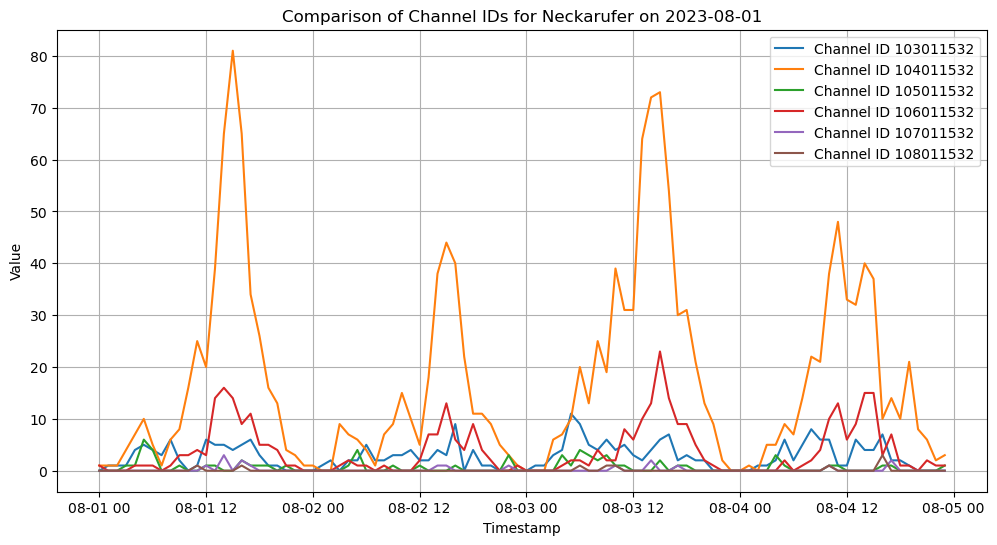

In [25]:
# Check, if data from different Channel-IDs is actually different

channel_id_list = [103011532, 104011532, 105011532, 106011532, 107011532, 108011532]

start = pd.Timestamp("2023-08-01")
end   = pd.Timestamp("2023-08-05")
plt.figure(figsize=(12, 6))

for c in channel_id_list:
    data_channel = data_counter_site[data_counter_site['channel_id'] == c]
    data_channel['iso_timestamp'] = pd.to_datetime(data_channel['iso_timestamp']).dt.tz_localize(None)
    data_channel_day = data_channel.query("@start <= iso_timestamp < @end")
    plt.plot(data_channel_day['iso_timestamp'], data_channel_day['zählstand'], label=f'Channel ID {c}')
    
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title(f'Comparison of Channel IDs for {counter_site} on {start.date()}')
plt.legend()
plt.grid()
plt.show()

In [26]:
print(data.shape)
print(data.info())

(16827970, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16827970 entries, 0 to 16827969
Data columns (total 16 columns):
 #   Column           Dtype              
---  ------           -----              
 0   timestamp        object             
 1   iso_timestamp    datetime64[ns, UTC]
 2   zählstand        int64              
 3   stand            int64              
 4   standort         object             
 5   channel_name     object             
 6   channel_id       int64              
 7   counter_site     object             
 8   counter_site_id  int64              
 9   domain_name      object             
 10  domain_id        int64              
 11  longitude        float64            
 12  latitude         float64            
 13  timezone         object             
 14  interval         int64              
 15  counter_serial   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(6), object(7)
memory usage: 2.0+ GB
None


#### Preprocess Data

In [5]:
## Clean data
data_cleaned = data.copy()

# 1. Time
# 'Isotimestamp' is local time and considers 'Sommerzeit'. Therefore, we use this for better accuracy in time representation.
# Exchange 'timestemp' with 'iso_timestamp' and convert to datetime with UTC timezone.
# Drop 'timezone' as this is identical for all entries.
# Drop 'interval' as this is equal for all entries (15 minutes).
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['iso_timestamp'], utc = True, errors='coerce') 
data_cleaned = data_cleaned.drop(columns=['iso_timestamp', 'timezone', 'interval'])

# 2. City
# Drop 'domain_name' as this is identical to 'standort'.
# Drop 'domain_id' as this is not informative.
# Rename 'standort' to 'city' for clarity.
data_cleaned = data_cleaned.rename(columns={'standort': 'city'})
data_cleaned = data_cleaned.drop(columns=['domain_name', 'domain_id'])

# 3. Counter
# Drop 'counter_serial' as this is not informative and has many missing values.
# Drop 'stand' as this is not informative.
# Rename 'counter_site' to 'counter_site_name' for clarity.
# Note: For further analysis, use 'counter_site_id' to uniquely identify counter sites.
data_cleaned = data_cleaned.rename(columns={'counter_site': 'counter_site_name'})
data_cleaned = data_cleaned.drop(columns=['counter_serial', 'stand'])

# 4. Channel
# TODO: Drop invalid channels (e.g., channel tracking cars, stand?)
# Note: For further analysis, use 'channel_id' to uniquely identify channels.
car_channels = [col for col in data_cleaned['channel_name'].unique() if 'Auto' in col or 'auto' in col or 'PKW' in col or 'pkw' in col or 'Car' in col or 'car' in col or 'Vehicle' in col or 'vehicle' in col or 'Fahrzeug' in col or 'fahrzeug' in col]
pedestrian_channels = [col for col in data_cleaned['channel_name'].unique() if 'Fußgänger' in col or 'Fussgänger' in col or 'fußgänger' in col or 'fussgänger' in col or 'Person' in col or 'person' in col or 'pedestrian' in col or 'Pedestrian' in col]
valid_channels = [col for col in data_cleaned['channel_name'].unique() if col not in car_channels and col not in pedestrian_channels]
data_cleaned = data_cleaned[data_cleaned['channel_name'].isin(valid_channels)]


# 5. Count
# Rename 'zählstand' to 'count' for clarity.
data_cleaned = data_cleaned.rename(columns={'zählstand': 'count'})

# Save cleaned data
data_cleaned.to_csv("../data/cleaned_fahrradzaehler_daten.csv", index=False)

data_cleaned.head()

,timestamp,count,city,channel_name,channel_id,counter_site_name,counter_site_id,longitude,latitude
0,2013-01-01 00:00:00+00:00,15,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,8.402715,49.007286
1,2013-01-01 01:00:00+00:00,17,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,8.402715,49.007286
2,2013-01-01 02:00:00+00:00,14,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,8.402715,49.007286
3,2013-01-01 03:00:00+00:00,13,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,8.402715,49.007286
4,2013-01-01 04:00:00+00:00,9,Stadt Karlsruhe,Erbprinz. West,101004165,Erbprinzenstraße,100004165,8.402715,49.007286


In [4]:
print(data_cleaned.shape)
print(data_cleaned.info())

(16499492, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 16499492 entries, 0 to 16827969
Data columns (total 9 columns):
 #   Column             Dtype              
---  ------             -----              
 0   timestamp          datetime64[ns, UTC]
 1   count              int64              
 2   city               object             
 3   channel_name       object             
 4   channel_id         int64              
 5   counter_site_name  object             
 6   counter_site_id    int64              
 7   longitude          float64            
 8   latitude           float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(3), object(3)
memory usage: 1.2+ GB
None


In [7]:
## Determine median as representative value for each city and normalize data

# 1. The hourly count of a counter site is the sum of the counts of all its channels within that hour
counter_sum = (
    data_cleaned
    .groupby(["city", "counter_site_id", "timestamp"])["count"]
    .sum()
    .reset_index(name="counter_sum")
)
# 2. Compute the median count per hour for each city 
city_medians = (
    counter_sum
    .groupby(['city', 'timestamp'])['counter_sum']
    .median()
    .reset_index(name="median_count")
)

# 3. Compute the overall median count for each city & IQR
yearly_stats = (
    city_medians
    .groupby("city")["median_count"]
    .agg(
        median_count_overall="median",
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75),
    )
)
yearly_stats["IQR"] = yearly_stats["q3"] - yearly_stats["q1"]

# 4. Normalize: (x - median_count_overall) / IQR
city_norm = city_medians.merge(
    yearly_stats[["median_count_overall", "IQR"]],
    on="city",
    how="left"
)

# 5. Avoid division by zero
city_norm["normalized_count"] = (
    (city_norm["median_count"] - city_norm["median_count_overall"])
    .div(city_norm["IQR"].replace(0, pd.NA))
)
city_norm["normalized_count"] = city_norm["normalized_count"].fillna(0)

city_coords = (
    data_cleaned
    .groupby("city")
    .agg(
        city_lat=("latitude", "mean"),
        city_lon=("longitude", "mean")
    )
    .reset_index()
)
city_norm_with_coords = city_norm.merge(city_coords, on="city", how="left")

# Save normalized data
city_norm_with_coords.to_csv("../data/normalized_city_fahrradzaehler_daten.csv", index=False)
city_norm_with_coords.head()

,city,timestamp,median_count,median_count_overall,IQR,normalized_count,city_lat,city_lon
0,Landeshauptstadt Stuttgart,2013-01-01 00:00:00+00:00,5.0,20.5,48.0,-0.322917,48.779347,9.177695
1,Landeshauptstadt Stuttgart,2013-01-01 01:00:00+00:00,3.0,20.5,48.0,-0.364583,48.779347,9.177695
2,Landeshauptstadt Stuttgart,2013-01-01 02:00:00+00:00,2.0,20.5,48.0,-0.385417,48.779347,9.177695
3,Landeshauptstadt Stuttgart,2013-01-01 03:00:00+00:00,0.0,20.5,48.0,-0.427083,48.779347,9.177695
4,Landeshauptstadt Stuttgart,2013-01-01 04:00:00+00:00,2.0,20.5,48.0,-0.385417,48.779347,9.177695


#### Plots

##### Number counts per Location per Year

In [ ]:
# TODO: at the moment not working due to datetime format

# Check yearly number of counts per standort 

# Extract date from timestamp
data['date'] = data['timestamp'].dt.date

# Step 1: Get max zählstand per standort, counter_serial, and date    #TODO: warum das Maximum extrahieren statt einfach alle zählstände zusammenzuaddieren?
max_per_counter = data.groupby(['standort', 'counter_serial', 'date'])['zählstand'].max().reset_index() #TODO: lieber counter_side_id nutzen?

# Step 2: Sum these maxima per standort and date
daily_counts = max_per_counter.groupby(['standort', 'date'])['zählstand'].sum().reset_index()
daily_counts = daily_counts.rename(columns={'zählstand': 'daily_counts'})

# Step 3: Now aggregate to yearly counts
daily_counts['year'] = pd.to_datetime(daily_counts['date']).dt.year
yearly_counts = daily_counts.groupby(['standort', 'year'])['daily_counts'].sum().reset_index()
yearly_counts = yearly_counts.rename(columns={'daily_counts': 'yearly_counts'})

print("Jährliche Zählungen pro Standort:")
yearly_counts

In [ ]:
# Plot the yearly counts per standort #TODO: sind das nicht eher die Tages-Maximas aufsummiert und nicht die tatsächlichen counts?
def thousands(x, pos):
    return f'{int(x/1000)}'

standorte = yearly_counts['standort'].unique()
colors = cm.get_cmap('tab20', len(standorte))  

plt.figure(figsize=(12, 6))
for i, standort in enumerate(standorte):
    subset = yearly_counts[yearly_counts['standort'] == standort]
    plt.plot(subset['year'], subset['yearly_counts'], marker='o', 
             label=standort, color=colors(i))

plt.title("Jährliche Fahrradzählungen pro Standort")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Fahrradzählungen (in Tsd.)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# For Konstanz, check how many counters there are per year
konstanz_data = data[data['standort'] == 'Stadt Konstanz']
counters_per_year_konstanz = konstanz_data.groupby('year')['counter_serial'].nunique()
counters_per_year_konstanz

In [ ]:
# Plot the number of counters per year in Konstanz
plt.figure(figsize=(8, 5))
plt.plot(counters_per_year_konstanz.index, counters_per_year_konstanz.values, marker='o')
plt.title("Anzahl der Zähler pro Jahr in Konstanz")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Zähler")
plt.show()

In [ ]:
## Normalize counts per location by number of counters

# First, calculate number of active counters per standort and date i.e. counters that have non-null zählstand on that date as max value
active_counters = data.groupby(['standort', 'counter_serial', 'date'])['zählstand'].max().reset_index()
active_counters = active_counters[active_counters['zählstand'].notnull()]
active_counters = active_counters.groupby(['standort', 'date'])['counter_serial'].nunique().reset_index()
active_counters = active_counters.rename(columns={'counter_serial': 'num_active_counters'})

# Merge mit daily_counts
daily_counts = daily_counts.merge(active_counters, on=['standort', 'date'], how='left')

# Normalize daily counts
daily_counts['normalized_daily_counts'] = daily_counts['daily_counts'] / daily_counts['num_active_counters']


# Aggregate to yearly normalized counts
normalized_yearly_counts = daily_counts.groupby(['standort', 'year'])['normalized_daily_counts'].sum().reset_index()
normalized_yearly_counts = normalized_yearly_counts.rename(columns={'normalized_daily_counts': 'normalized_yearly_counts'})

print("Normalisierte jährliche Zählungen pro Standort:")
normalized_yearly_counts

In [ ]:
# Plot the normalized yearly counts per standort
def thousands(x, pos):
    return f'{int(x/1000)}'

standorte = normalized_yearly_counts['standort'].unique()
colors = cm.get_cmap('tab20', len(standorte))  # Colormap

plt.figure(figsize=(12, 6))
for i, standort in enumerate(standorte):
    subset = normalized_yearly_counts[normalized_yearly_counts['standort'] == standort]
    plt.plot(subset['year'], subset['normalized_yearly_counts'], marker='o',  # hier die Jahreswerte verwenden!
             label=standort, color=colors(i))

plt.title("Jährliche Fahrradzählungen pro Standort (normalisiert)")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Fahrradzählungen/# Aktive Tracker (in Tsd.)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# printe für jeden Standort die Anzahl der Datenpunkte
for location in data['standort'].unique():
    count = data[(data['standort'] == location)].shape[0]
    if count > 0:
        print(f"Standort: {location}, Anzahl der Datenpunkte: {count}")

#printe für jeden Standort alle Channel-Namen:
for location in data['standort'].unique():
    channel_names = data[data['standort'] == location]['channel_name'].unique()
    print(f"Standort: {location}, Channel Names: {channel_names}")

# printe für jeden Channel Name am Standort Stadt Freiburg die Anzahl der Datenpunkte:
for channel_name in data['channel_name'].unique():
    count = data[(data['standort'] == "Stadt Freiburg") & (data['channel_name'] == channel_name)].shape[0]
    if count > 0:
        print(f"Standort: Stadt Freiburg, Channel Name: {channel_name}, Anzahl der Datenpunkte: {count}")

"""for location in data['standort'].unique():
    for channel_name in data['channel_name'].unique():
        count = data[(data['standort'] == location) & (data['channel_name'] == channel_name)].shape[0]
        if count > 0:
            print(f"Standort: {location}, Channel Name: {channel_name}, Anzahl der Datenpunkte: {count}")
"""

In [ ]:
# prüfe, für jeden Standort, wie viele Datenpunkte es gibt 
#for location in data['standort'].unique():
location = "Stadt Freiburg"
for site_id in data['counter_site_id'].unique():
    count = data[(data['standort'] == location) & (data['counter_site_id'] == site_id)].shape[0]
    if count > 0:
        print(f"Standort: {location}, Counter Side ID: {site_id}, Anzahl der Datenpunkte: {count}")

for channel_name in data['channel_name'].unique():
    count = data[(data['standort'] == location) & (data['channel_name'] == channel_name)].shape[0]
    if count > 0:
        print(f"Standort: {location}, Channel Name: {channel_name}, Anzahl der Datenpunkte: {count}")            

In [ ]:
#printe für jeden Standort, Channel Name und Counter Site ID die Anzahl der Datenpunkte
for location in data['standort'].unique():
    data_standort = data[data['standort'] == location]
    for site_id in data_standort['counter_site_id'].unique():
        for channel_name in data_standort['channel_name'].unique():
            count = data[(data['standort'] == location) & (data['counter_site_id'] == site_id) & (data['channel_name'] == channel_name)].shape[0]
            if count > 0:
                print(f"Standort: {location}, Channel Name: {channel_name}, Counter Side ID: {site_id}, Anzahl der Datenpunkte: {count}")


In [ ]:
from datetime import datetime

# prüfe für jeden Counter (Kombination aus Standort, Channel_name und Counter_Site_ID), 
# was der jeweils früheste und späteste timestamp ist
# schreibe standort, channel_name, frühester und spätester timestamp in pandas dataframe
start_end_timestamps = pd.DataFrame(columns=['standort', 'channel_name', 'counter_site_id', 'earliest_timestamp', 'latest_timestamp'])

for location in data['standort'].unique():
    data_standort = data[data['standort'] == location]
    for site_id in data_standort['counter_site_id'].unique():
        for channel_name in data_standort['channel_name'].unique():
            subset = data[(data['standort'] == location) & (data['counter_site_id'] == site_id) & (data['channel_name'] == channel_name)]
            if not subset.empty:
                earliest = subset['timestamp'].min().replace(tzinfo=None)
                latest = subset['timestamp'].max().replace(tzinfo=None)

                start_end_timestamps = pd.concat([start_end_timestamps, pd.DataFrame([{
                    'standort': location,
                    'channel_name': channel_name,
                    'counter_site_id': site_id,
                    'earliest_timestamp': earliest,
                    'latest_timestamp': latest
                }])], ignore_index=True)                       
                
    print(location)
                
    """if earliest > datetime(2013, 1, 1, 1, 0, 0) or latest < datetime(2024, 12, 31, 23, 0, 0):
    #datetime(2023, 11, 7, 14, 30, 0)  # Jahr, Monat, Tag, Stunde, Minute, Sekunde
        print(f"{location}, {channel_name}, Frühester Timestamp: {earliest}, Spätester Timestamp: {latest}")
    else:
        print(f"{location}, {channel_name}, passt zeitlich")"""


In [ ]:
# schreibe start_end_timestamps in csv-datei
start_end_timestamps.to_csv("start_end_timestamps.csv", index=False)